# Fully connected feedforward network implementing a loss mask

In [ ]:
import torchmetrics.classification
from torch import cuda
assert cuda.is_available()
assert cuda.device_count() > 0

In [ ]:
print(cuda.get_device_name(cuda.current_device()))


NVIDIA GeForce RTX 3060 Ti


In [ ]:
import torch
import torch.nn as nn

In [ ]:
DEVICE = torch.device("cuda")
SEED = 76436278

torch.manual_seed(SEED)

### Load the Dataset

In [ ]:
replace_dict ={
"Ofloxacin Merged": "Levofloxacin",
"Benzylpenicillin": "Penicillin",
"Benzylpenicillin_others": "Penicillin",
"Benzylpenicillin_with_meningitis": "Penicillin",
"Benzylpenicillin_with_pneumonia":"Penicillin",
"Penicillin_with_endokarditis": "Penicillin",
"Penicillin_without_endokarditis": "Penicillin",
"Penicillin_without_meningitis":"Penicillin",
"Penicillin_with_meningitis": "Penicillin",
"Penicillin_with_pneumonia": "Penicillin",
"Penicillin_with_other_infections": "Penicillin",
"Cefuroxime.1": "Cefuroxime",
"Cotrimoxazol": "Cotrimoxazole",
"Gentamicin_high_level": "Gentamicin",
"Cefoxitin_screen": "Cefoxitin",
"Teicoplanin_GRD": "Teicoplanin",
"Vancomycin_GRD": "Vancomycin",
"Rifampicin_1mg-l": "Rifampicin",
"Meropenem_with_meningitis": "Meropenem",
"Meropenem_without_meningitis": "Meropenem",
"Meropenem_with_pneumonia": "Meropenem",
"Amoxicillin-Clavulanic acid_uncomplicated_HWI": "Amoxicillin-Clavulanic acid",
}

In [ ]:
from src.maldi2resistance.data.driams import Driams

driams = Driams(
    root_dir="/home/jan/Uni/master/data/Driams",
    replace_drug_names= replace_dict,
)

driams.loading_type = "memory"

driams

/home/jan/Uni/master/src/maldi2resistance/data/driams.py:72: DtypeWarning: Columns (71) have mixed types. Specify dtype option on import or set low_memory=False.
  self.__meta[key] = pd.read_csv(root_dir / f"{site}/id/{year}/{year}_clean.csv")


Merging Antibiotics for ('DRIAMS-A', 2015):   0%|          | 0/22 [00:00<?, ?it/s]

Merging Antibiotics for ('DRIAMS-A', 2016):   0%|          | 0/22 [00:00<?, ?it/s]

Merging Antibiotics for ('DRIAMS-A', 2017):   0%|          | 0/22 [00:00<?, ?it/s]

Merging Antibiotics for ('DRIAMS-A', 2018):   0%|          | 0/22 [00:00<?, ?it/s]

Merging Antibiotics for ('DRIAMS-B', 2018):   0%|          | 0/22 [00:00<?, ?it/s]

Merging Antibiotics for ('DRIAMS-C', 2018):   0%|          | 0/22 [00:00<?, ?it/s]

Merging Antibiotics for ('DRIAMS-D', 2018):   0%|          | 0/22 [00:00<?, ?it/s]

Loading Spectra into Memory:   0%|          | 0/53978 [00:00<?, ?it/s]

Antibiotic:,Amikacin,Ampicillin,Ampicillin-Amoxicillin,Aztreonam,Cefazolin,Cefepime,Cefpodoxime,Ceftazidime,Ceftriaxone,Ciprofloxacin,Clarithromycin,Clindamycin,Colistin,Ertapenem,Erythromycin,Fosfomycin,Fosfomycin-Trometamol,Fusidic acid,Imipenem,Mupirocin,Nitrofurantoin,Norfloxacin,Oxacillin,Piperacillin-Tazobactam,Polymyxin B,Tetracycline,Tobramycin
Number resistant:,1068,8578,21966,628,4223,7383,2338,3470,8659,9338,310,4381,2874,427,5468,2303,1326,3620,7560,570,1271,1205,5537,7616,486,3534,1707
Number susceptible:,20941,4194,4905,456,5813,31567,4382,24566,28464,36822,1262,9841,15784,21740,9044,10184,4803,8498,31717,4656,3603,7031,7740,31308,2305,10376,16809
Number data points:,22009,12772,26871,1084,10036,38950,6720,28036,37123,46160,1572,14222,18658,22167,14512,12487,6129,12118,39277,5226,4874,8236,13277,38924,2791,13910,18516


In [ ]:
driams.label_stats

,Amikacin,Ampicillin,Ampicillin-Amoxicillin,Aztreonam,Cefazolin,Cefepime,Cefpodoxime,Ceftazidime,Ceftriaxone,Ciprofloxacin,...,Fusidic acid,Imipenem,Mupirocin,Nitrofurantoin,Norfloxacin,Oxacillin,Piperacillin-Tazobactam,Polymyxin B,Tetracycline,Tobramycin
positive,1068,8578,21966,628,4223,7383,2338,3470,8659,9338,...,3620,7560,570,1271,1205,5537,7616,486,3534,1707
negative,20941,4194,4905,456,5813,31567,4382,24566,28464,36822,...,8498,31717,4656,3603,7031,7740,31308,2305,10376,16809
n_sum,22009,12772,26871,1084,10036,38950,6720,28036,37123,46160,...,12118,39277,5226,4874,8236,13277,38924,2791,13910,18516


In [ ]:
import json

df = json.load(open("/home/jan/Uni/master/data/Driams/driams_split.json"))

for key, value in df.items():
    if value in ["A_train", "B_train", "C_train", "D_train"]:
        df[key] = "train"
    elif value in ["A_test", "B_test", "C_test", "D_test"]:
        df[key] = "test"

In [ ]:
indices_train = []
indices_test = []

for idx in range(len(driams)):
    site, year, code = driams.get_site_year_key(idx)
    if site != "DRIAMS-A":
        continue
    
    key = f"{site}/{year}/{code}.txt"
    
    if df[key] == "train":
        indices_train.append(idx)
    elif df[key] == "test":
        indices_test.append(idx)
    else:
        continue
        

In [ ]:
len(indices_train)

26879

In [ ]:
len(indices_test)

4826

In [ ]:
from torch.utils.data import Subset

test_set = Subset(driams, indices= indices_test)
train_set = Subset(driams, indices=indices_train)

In [ ]:
len(driams.label_stats.columns)

27

In [ ]:
from maldi2resistance.model.MLP import AeBasedMLP

model = AeBasedMLP(input_dim=18000, output_dim=len(driams.selected_antibiotics), hidden_dim=4096, latent_dim=2048)
model.to(DEVICE)

AeBasedMLP(
  (encoder): Encoder(
    (input): Linear(in_features=18000, out_features=4096, bias=True)
    (layer_1): Linear(in_features=4096, out_features=4096, bias=True)
    (layer_2): Linear(in_features=4096, out_features=2048, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (decoder): Decoder(
    (input): Linear(in_features=2048, out_features=4096, bias=True)
    (layer_1): Linear(in_features=4096, out_features=4096, bias=True)
    (layer_2): Linear(in_features=4096, out_features=27, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
gen = torch.Generator()


batch_size = 128

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory= True)

In [ ]:
from maldi2resistance.loss.maskedLoss import MaskedBCE
from tqdm.auto import tqdm
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

print("Start training ...")
model.train()

optimizer = Adam(model.parameters(), lr=1e-3, amsgrad = True)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
loss_per_batch = []


class_weights_negative = torch.tensor((1 - (driams.label_stats.loc["negative"] / driams.label_stats.loc["n_sum"])).values, device=DEVICE)
class_weights_positive = torch.tensor((1 - (driams.label_stats.loc["positive"] / driams.label_stats.loc["n_sum"])).values, device=DEVICE)

criterion = MaskedBCE(class_weights_positive= class_weights_negative, class_weights_negative= class_weights_negative)

for epoch in tqdm(range(30)):
    overall_loss = 0
    
    for batch_idx, (x, y) in enumerate(train_loader):

        x = x.to(DEVICE,non_blocking=True)
        y = y.to(DEVICE,non_blocking=True)
        
        optimizer.zero_grad()
        output = model(x)
        
        loss = criterion(output, y)

        current_loss_value = loss.item()
        loss_per_batch.append(current_loss_value)
        
        overall_loss += current_loss_value
        
        loss.backward()
        optimizer.step()

    scheduler.step()
    with tqdm.external_write_mode():
        print(f"\tAverage Loss: {overall_loss / (batch_idx*batch_size):.6f} \tLearning rate: {scheduler.get_last_lr()[0]:.6f}")


print("Finish")

Start training ...


  0%|          | 0/30 [00:00<?, ?it/s]

	Average Loss: 0.000316 	Learning rate: 0.001000
	Average Loss: 0.000261 	Learning rate: 0.001000
	Average Loss: 0.000240 	Learning rate: 0.001000
	Average Loss: 0.000227 	Learning rate: 0.001000
	Average Loss: 0.000217 	Learning rate: 0.001000
	Average Loss: 0.000206 	Learning rate: 0.001000
	Average Loss: 0.000203 	Learning rate: 0.001000
	Average Loss: 0.000196 	Learning rate: 0.001000
	Average Loss: 0.000190 	Learning rate: 0.001000
	Average Loss: 0.000182 	Learning rate: 0.000500
	Average Loss: 0.000162 	Learning rate: 0.000500
	Average Loss: 0.000154 	Learning rate: 0.000500
	Average Loss: 0.000150 	Learning rate: 0.000500
	Average Loss: 0.000143 	Learning rate: 0.000500
	Average Loss: 0.000139 	Learning rate: 0.000500
	Average Loss: 0.000135 	Learning rate: 0.000500
	Average Loss: 0.000127 	Learning rate: 0.000500
	Average Loss: 0.000123 	Learning rate: 0.000500
	Average Loss: 0.000117 	Learning rate: 0.000500
	Average Loss: 0.000109 	Learning rate: 0.000250
	Average Loss: 0.000

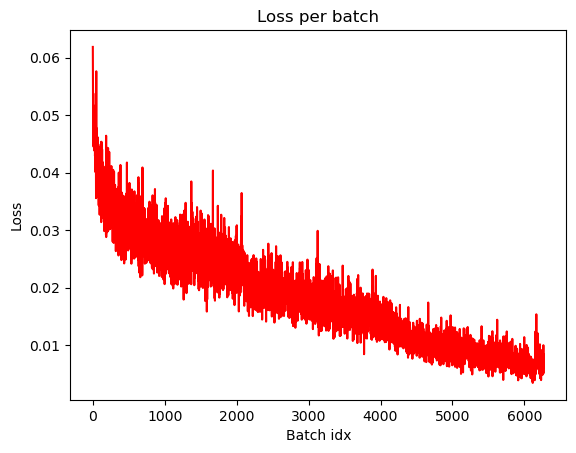

In [ ]:
import matplotlib.pyplot as plt 

plt.title("Loss per batch") 
plt.xlabel("Batch idx") 
plt.ylabel("Loss") 
plt.plot(list(range(0,len(loss_per_batch))),loss_per_batch , color ="red") 
plt.show()

In [ ]:
model.eval()

AeBasedMLP(
  (encoder): Encoder(
    (input): Linear(in_features=18000, out_features=4096, bias=True)
    (layer_1): Linear(in_features=4096, out_features=4096, bias=True)
    (layer_2): Linear(in_features=4096, out_features=2048, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (decoder): Decoder(
    (input): Linear(in_features=2048, out_features=4096, bias=True)
    (layer_1): Linear(in_features=4096, out_features=4096, bias=True)
    (layer_2): Linear(in_features=4096, out_features=27, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)

In [ ]:
torch.save({
            'model_state_dict': model.state_dict(),
            'selected_antibiotics': driams.selected_antibiotics
            }, './model.pt')

In [ ]:
import gc

torch.cuda.empty_cache()
gc.collect()

4080

In [ ]:
test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=True)
test_features, test_labels = next(iter(test_loader))

In [ ]:
test_features = test_features.to(DEVICE)
test_labels = test_labels.to(DEVICE)

In [ ]:
output = model(test_features)

(0.8780769109725952, 0.7282666122471845)


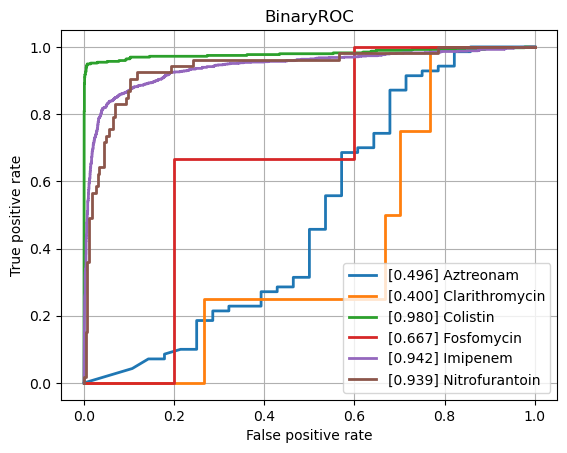

In [ ]:
from maldi2resistance.metric.ROC import MultiLabelRocNan
import matplotlib.pyplot as plt

ml_roc = MultiLabelRocNan()
print(ml_roc.compute(output,test_labels,driams.selected_antibiotics, create_csv="./ROC_results.csv"))
fig_, ax_ = ml_roc()

plt.savefig("./ROC_results.png", transparent=True, format= "png", bbox_inches = "tight")
plt.show()

(0.8008812069892883, 0.5277257575825961)


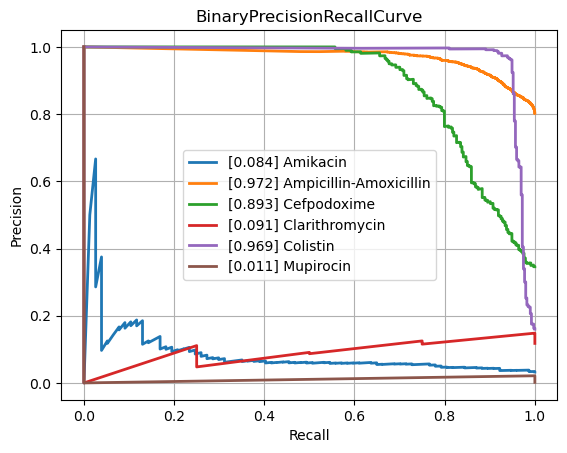

In [ ]:
from maldi2resistance.metric.PrecisionRecall import MultiLabelPRNan
import matplotlib.pyplot as plt

ml_pr = MultiLabelPRNan()
print(ml_pr.compute(output,test_labels,driams.selected_antibiotics, create_csv="./PR_results.csv"))

fig_, ax_ = ml_pr()

plt.savefig("./PR_results.png", transparent=True, format= "png", bbox_inches = "tight")
plt.show()